# Project

In [1]:
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

## Sinan Bursa

In [2]:
credits = pd.read_csv('../../data/tmdb_5000_credits.csv')
credits = credits[credits.cast != '[]']


movies = pd.read_csv('../../data/tmdb_5000_movies.csv')
movies.drop(['homepage', 'keywords','original_language','overview','release_date','spoken_languages', \
             'status','title','tagline','vote_count'\
            ], \
            axis=1, \
            inplace=True \
           )

In [3]:
credits.drop(['title', 'crew'], axis=1, inplace=True)
credits['cast_id'] = credits['cast'].apply(lambda row: list(set(pd.read_json(row)['id'])))
#credits['cast_name'] = credits['cast'].apply(lambda row: list(set(pd.read_json(row)['name'])))
#credits['gender'] = credits['cast'].apply(lambda row: list(set(pd.read_json(row)['gender'])))

In [4]:
frames = pd.DataFrame()
new_df = pd.DataFrame()

for idx, film in credits.iterrows():
    cast_df = pd.DataFrame(eval(credits['cast'][idx]))
    cast_df['credits'] = idx
    cast_df = cast_df.drop(['character','order', 'credit_id', 'cast_id'],axis = 1)  
    
    frames = [new_df, cast_df]
    new_df = pd.concat(frames, join = 'outer', ignore_index=True)

In [5]:
discount_old = credits['cast_id'].apply(pd.Series).stack().value_counts()
discount_old = list(discount_old[discount_old > 4].index.astype(int))
#discount_old[:10]

In [6]:
nodes_df = new_df['credits'].groupby([new_df.gender, new_df.id, new_df.name]).apply(list).reset_index()
nodes_df = nodes_df[nodes_df['gender'].isin(['1','2'])]
discount_1 = nodes_df['id'].tolist()
discount = [x for x in discount_old if x in discount_1]
#nodes_df = nodes_df[nodes_df.id.isin(discount)]
#nodes_df.drop(columns=['credits'], inplace=True)
#nodes_df = nodes_df[nodes_df['gender'].isin(['1','2'])]

In [7]:
print('Old Values of the Discount')
print(discount_old[:10])
print(len(discount_old))
print('New Values of the Discount')
print(discount[:10])
print(len(discount))

Old Values of the Discount
[2231, 380, 62, 1892, 192, 884, 3896, 887, 85, 2963]
3766
New Values of the Discount
[2231, 380, 62, 1892, 192, 884, 3896, 887, 85, 2963]
3500


In [8]:
credits['cast_id'] = credits['cast_id'].apply(lambda x: [y for y in x if y in discount])
credits['edges'] = credits['cast_id'].apply(lambda x: list(itertools.combinations(x, 2)))
edges = list(credits['edges'].apply(pd.Series).stack())
edges[0:5]

edges_df = pd.DataFrame(edges)

In [9]:
#Normally the number of edges was:
print('Normally the number of edges was:')
print(edges_df)

Normally the number of edges was:
            0      1
0       30485  98215
1       30485  42286
2       30485  68278
3       30485  65731
4       30485  42317
5       30485  10964
6       30485  10205
7       30485  59231
8       30485  32747
9       30485   1771
10      30485  15853
11      30485  17647
12      30485   8691
13      98215  42286
14      98215  68278
15      98215  65731
16      98215  42317
17      98215  10964
18      98215  10205
19      98215  59231
20      98215  32747
21      98215   1771
22      98215  15853
23      98215  17647
24      98215   8691
25      42286  68278
26      42286  65731
27      42286  42317
28      42286  10964
29      42286  10205
...       ...    ...
185261   8263  52442
185262   8263  26716
185263  24305  21042
185264  24305  59254
185265  24305  52442
185266  24305  26716
185267  21042  59254
185268  21042  52442
185269  21042  26716
185270  59254  52442
185271  59254  26716
185272  52442  26716
185273   1736    429
185274   1733  20173


In [10]:
edges_df = edges_df.merge(nodes_df, left_on = 0, right_on='id', how='inner').drop(columns=['name','credits'])
edges_df = edges_df.merge(nodes_df, left_on = 1, right_on='id', how='inner').drop(columns=['name','credits'])

In [11]:
edges_df.head()

,0,1,gender_x,id_x,gender_y,id_y
0,30485,98215,1,30485,2,98215
1,56448,98215,2,56448,2,98215
2,15376,98215,2,15376,2,98215
3,6807,98215,2,6807,2,98215
4,1196960,98215,2,1196960,2,98215


In [12]:
edges_df['same_gender']=0
for i in range(len(edges_df)):
    if edges_df['gender_x'][i]==edges_df['gender_y'][i]:
        edges_df['same_gender'][i]=1

In [13]:
edges_df = edges_df.drop(columns=['gender_x','id_x','gender_y','id_y'])
edges_df =edges_df[edges_df['same_gender'] == 1]
edges_df = edges_df.drop(columns=['same_gender'])
edges_df = edges_df.reset_index(drop=True)

In [14]:
len(edges_df)

114445

In [15]:
edges_df.head()

,0,1
0,56448,98215
1,15376,98215
2,6807,98215
3,1196960,98215
4,10884,98215


In [16]:
discarded_movies = set()

for idx, movie in credits.iterrows():
    if len(movie['edges']) == 0:
        discarded_movies.add(movie['movie_id'])

print(len(discarded_movies)) 

663


In [17]:
credits = credits[~credits['movie_id'].isin(discarded_movies)]
credits.head()

,movie_id,cast,cast_id,edges
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[30485, 98215, 42286, 68278, 65731, 42317, 109...","[(30485, 98215), (30485, 42286), (30485, 68278..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[2440, 2441, 2449, 2452, 1709, 1711, 1714, 171...","[(2440, 2441), (2440, 2449), (2440, 2452), (24..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[139549, 17064, 543530, 27319, 121529, 5309, 2...","[(139549, 17064), (139549, 543530), (139549, 2..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[21505, 53252, 77335, 535, 539, 1580574, 22075...","[(21505, 53252), (21505, 77335), (21505, 535),..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[17287, 17419, 2206, 2983, 5293, 21044, 57675,...","[(17287, 17419), (17287, 2206), (17287, 2983),..."


In [18]:
movies['profit'] = movies['revenue']-movies['budget']
movies_credits = movies.merge(credits, left_on='id', right_on='movie_id', how='inner').drop(columns=['movie_id'])

In [19]:
movies_credits = movies_credits[movies_credits.genres != '[]']
movies_credits['genre_id'] = movies_credits['genres'].apply(lambda row: list(set(pd.read_json(row)['id'])))

In [20]:
profit_df = pd.DataFrame(movies_credits.cast_id.tolist(), index=movies_credits.profit).stack().reset_index(name='cast_id')[['cast_id','profit']]
profit_df['cast_id'] = profit_df.cast_id.astype(int)
profit_df = profit_df.groupby('cast_id', as_index=False).mean()
profit_df.set_index('cast_id', inplace=True)
profit_df.head()


,profit
cast_id,
3,1.596215e+08
4,1.594258e+08
6,5.387531e+08
7,4.952879e+08
10,6.340370e+08


In [21]:
profit_df = ((profit_df['profit']/(10**7)).round(0))*(10**7)
profit_df = profit_df.to_frame()

In [22]:
ranking_df = pd.DataFrame(movies_credits.cast_id.tolist(), index=movies_credits.vote_average).stack().reset_index(name='cast_id')[['cast_id','vote_average']]
ranking_df['cast_id'] = ranking_df.cast_id.astype(int)
ranking_df = ranking_df.groupby('cast_id', as_index=False).mean()
ranking_df.set_index('cast_id', inplace=True)
ranking_df.head()
     

,vote_average
cast_id,
3,6.634375
4,6.366667
6,7.437500
7,7.340000
10,7.466667


In [23]:
ranking_df = round(ranking_df['vote_average'] * 2) / 2
ranking_df = ranking_df.to_frame()

In [24]:
genre = movies_credits[['cast_id', 'genre_id']]
genre.loc[:, 'genre_id_disc'] = genre['genre_id'].apply(lambda x: x[0])

/Users/SinanBursa/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/SinanBursa/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
genre_df = pd.DataFrame(genre.cast_id.tolist(), index=genre.genre_id_disc).stack().reset_index(name='cast_id')[['cast_id','genre_id_disc']]
most_freq_genre = genre_df.groupby(['cast_id']).agg(lambda x:x.value_counts().index[0])


In [26]:
actors = ranking_df.merge(most_freq_genre, on='cast_id', how='inner')
actors = actors.merge(profit_df, on='cast_id', how='inner')

In [27]:
actors = actors.reset_index()
actors.head()

,cast_id,vote_average,genre_id_disc,profit
0,3,6.5,18,160000000.0
1,4,6.5,80,160000000.0
2,6,7.5,12,540000000.0
3,7,7.5,16,500000000.0
4,10,7.5,16,630000000.0


In [28]:
#nodes_df = new_df['credits'].groupby([new_df.gender, new_df.id, new_df.name]).apply(list).reset_index()
nodes_df = nodes_df[nodes_df.id.isin(discount)]
nodes_df.drop(columns=['credits'], inplace=True)
#nodes_df = nodes_df[nodes_df['gender'].isin(['1','2'])]

In [29]:
actors = actors.merge(nodes_df, left_on = 'cast_id', right_on='id', how='inner').drop(columns=['cast_id'])

In [30]:
actors = actors[['name', 'id', 'gender', 'genre_id_disc', 'vote_average', 'profit']]

In [31]:
actors[actors['name']=='Leonardo DiCaprio']

,name,id,gender,genre_id_disc,vote_average,profit
824,Leonardo DiCaprio,6193,2,18,7.0,220000000.0


In [32]:
actors.sort_values(by='profit', ascending=False)

,name,id,gender,genre_id_disc,vote_average,profit
2396,Julene Renee,42286,1,16,6.5,870000000.0
306,Adrian Rawlins,1643,2,12,7.5,760000000.0
3411,Jamie Waylett,956224,2,12,7.5,750000000.0
1218,Bonnie Wright,10991,1,12,7.5,750000000.0
1253,Josh Herdman,11212,2,12,7.5,750000000.0
3282,Oliver Phelps,140368,2,12,7.5,750000000.0
3163,James Phelps,96851,2,12,7.5,750000000.0
3162,Matthew Lewis,96841,2,12,7.5,670000000.0
1992,Peter Mayhew,24343,2,12,8.0,640000000.0
3372,Devon Murray,234922,2,12,7.5,640000000.0


In [33]:
#features = nodes_df.set_index('id').drop('name', axis=1)
#features.head()

In [34]:
discount_df = pd.DataFrame(discount)
features = discount_df.merge(actors, left_on = 0, right_on='id', how='inner').drop(columns=[0])
features.head()

,name,id,gender,genre_id_disc,vote_average,profit
0,Samuel L. Jackson,2231,2,80,6.5,160000000.0
1,Robert De Niro,380,2,80,6.5,50000000.0
2,Bruce Willis,62,2,80,6.0,90000000.0
3,Matt Damon,1892,2,18,6.5,100000000.0
4,Morgan Freeman,192,2,18,6.5,140000000.0


## Doing the Adjacency again
Cause we took out some genders and our size went from 3766 to 3500

In [35]:
edges = edges_df.values.tolist()
len(edges)

114445

In [36]:
adj = pd.DataFrame(np.zeros(shape=(len(discount),len(discount))), columns=discount, index=discount)
for e1, e2 in edges:
    if e1 in discount and e2 in discount:
        adj.at[e1, e2] += 1
        adj.at[e2, e1] += 1
    else:
        edges.remove((e1,e2))

adj.head()

,2231,380,62,1892,192,884,3896,887,85,2963,...,59017,3272,15565,41746,59019,66288,3033,17187,51998,21318
2231,0.0,2.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
380,2.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
62,4.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,1.0,2.0,1.0,0.0,0.0,4.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#One outlier, its Katie Featherston, ID=90596, index number 3415

In [38]:
adjacency = adj.values
adj_max = adjacency.max()
adjacency = np.vectorize(lambda x: x/adj_max)(adjacency)

adjacency = pd.DataFrame(adjacency)

In [39]:
adjacency.head()

,0,1,2,3,4,5,6,7,8,9,...,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499
0,0.000000,0.166667,0.333333,0.000000,0.000000,0.166667,0.083333,0.000000,0.000000,0.166667,...,0.0,0.0,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0
1,0.166667,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.250000,0.000000,0.000000,...,0.0,0.0,0.0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.333333,0.083333,0.000000,0.083333,0.166667,0.166667,0.000000,0.166667,0.000000,0.083333,...,0.0,0.0,0.0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.083333,0.166667,0.083333,0.000000,0.000000,0.333333,0.083333,0.083333,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [40]:
#IF WE NEED NON WEIGHTED ADJACENCY
adjacency_non_weighted = np.copy(adjacency)
adjacency_non_weighted[adjacency_non_weighted > 0] = 1
adjacency_non_weighted = np.asmatrix(adjacency_non_weighted)

In [41]:
graph = nx.from_numpy_array(adjacency_non_weighted)

In [42]:
node_props = features.to_dict()

In [43]:
for key in node_props:
    nx.set_node_attributes(graph, node_props[key], key)

In [44]:
graph.node[0]

{'name': 'Samuel L. Jackson',
 'id': 2231,
 'gender': 2,
 'genre_id_disc': 80,
 'vote_average': 6.5,
 'profit': 160000000.0}

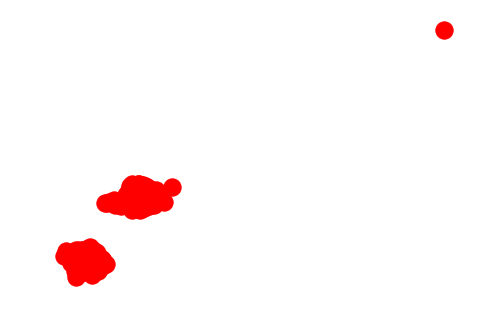

In [45]:
nx.draw_spring(graph)

In [46]:
nx.write_gexf(graph, 'CoAppGenderAdjGephiFile.gexf')

In [47]:
adjacency.to_csv("CoAppGenderAdjacency.csv")

In [48]:
features.to_csv("CoAppGenderFeatures.csv")

In [51]:
edges_df.to_csv("CoAppGenderEdges.csv")